WSI - Zadanie 2 <br/>
06.11.2023 <br/>
Wojciech Pobocha
318399


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [33]:
def f1(x1,y1):
    return (x1**2+y1-11)**2+(x1+y1**2-7)**2
def f2(x2,y2):
    return 2*x2**2+1.05*x2**4+(x2**6)/6+x2*y2+y2**2

def sumF1F2(individual):
    x1,y1,x2,y2 = individual
    return f1(x1,y1)+f2(x2,y2)

In [34]:
def getPlotVariables(minVariable, maxVariable, function):
    x = np.linspace(minVariable, maxVariable, 100)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)
    return X, Y, Z

In [35]:
def draw2DPlot(X,Y,Z,bestPoint=None, additionalPoints=None):

    plt.contourf(X,Y,Z, levels=20, colors='white')
    contour = plt.contour(X,Y,Z, levels=10, colors='black')
    plt.clabel(contour, inline=1, fontsize=8)

    if bestPoint is not None:
        plt.plot(bestPoint[0], bestPoint[1], 'ro')
    if additionalPoints is not None:
        plt.scatter(additionalPoints[:,0], additionalPoints[:,1],marker='.',s=30)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Wykresy funkcji, których suma jest funkcją celu

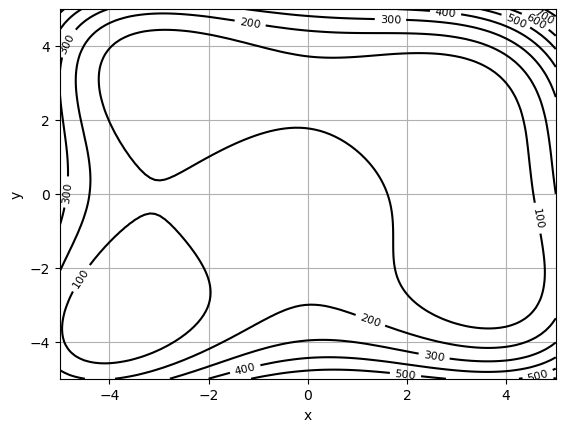

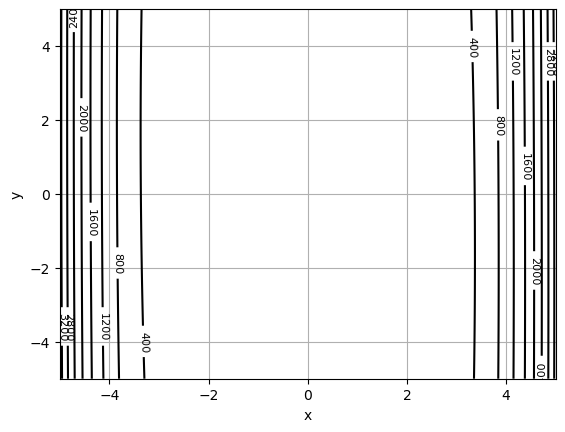

In [36]:
X1,Y1,Z1 = getPlotVariables(-5,5,f1)
draw2DPlot(X1,Y1,Z1)


X2,Y2,Z2 = getPlotVariables(-5,5,f2)
draw2DPlot(X2,Y2,Z2)

In [37]:
def gaussMutation(individual, sigma):
    mutatedIndividual = np.zeros(len(individual))
    for i in range(len(individual)):
        mutatedIndividual[i] = individual[i] + np.random.normal(0, sigma)
    return mutatedIndividual


In [38]:
def mutatePopulation(population, sigma):
    mutatedPopulation = []
    for individual in population:
        individual1 = gaussMutation(individual, sigma)
        mutatedPopulation.append(individual1)
    return mutatedPopulation

In [39]:
def individualSinglePointCrossBreeding(individual1, individual2):
    point = random.randint(0, len(individual1)-1)
    return np.concatenate((individual1[:point], individual2[point:]), axis=None)

In [40]:
def populationCrossBreeding(population, crossingProbability):
    random.shuffle(population)
    crossedPopulation = []
    for i in range(0, len(population), 2):
        if random.random() < crossingProbability:
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i], population[i+1]))
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i+1], population[i]))
        else:
            crossedPopulation.append(population[i])
            crossedPopulation.append(population[i+1])
    return crossedPopulation

In [41]:
def generateRandomPopulation(size, D):
    return [np.random.uniform(D[0], D[1], 4) for _ in range(size)]


In [43]:
def gradeIndividual(individual, D, gradingFunction):
    return gradingFunction(individual)

In [44]:
def gradePopulation(population,D,gradingFunction):
    sum = 0
    for individual in population:
        sum += gradeIndividual(individual,D,gradingFunction)
    return sum

In [45]:
def tournamentSelection(population,D, gradingFunction):
    populationAfterSelection = []

    for _ in range(len(population)):
        individual1 = random.choice(population)
        individual2 = random.choice(population)
        if gradeIndividual(individual1,D,gradingFunction) < gradeIndividual(individual2,D,gradingFunction):
            populationAfterSelection.append(individual1)
        else:
            populationAfterSelection.append(individual2)
    return populationAfterSelection


In [46]:
def bringIndividualToBoundres(individual, D):
    for i in range(len(individual)):
        individual[i] = max(D[0], min(D[1], individual[i]))
    return individual

In [47]:
def bringPopulationToBoundries(population, D):
    for individual in population:
        individual = bringIndividualToBoundres(individual,D)
    return population

In [48]:
def updateBestIndividual(population, lastBestIndividual,D,gradingFunction):
    bestIndividual = lastBestIndividual
    bestValue = gradeIndividual(lastBestIndividual,D,gradingFunction)
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < bestValue:
            bestIndividual = individual
            bestValue = gradeIndividual(individual,D,gradingFunction)
    return bestIndividual


In [49]:
def findBestIndividual(population,D,gradingFunction):
    best = population[0]
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < gradeIndividual(best,D,gradingFunction):
            best = individual
    return best

In [50]:
def generateValuesAroundPoint(size, point,sigma):
    return np.random.normal(point, sigma, (size, 2))

In [51]:
def generateSpecificF1Population(size, point, sigma, D):
    population = generateValuesAroundPoint(size, point, sigma)
    x2 = np.random.uniform(D[0], D[1], size)
    y2 = np.random.uniform(D[0], D[1], size)
    population = np.concatenate((population, np.array([x2,y2]).T), axis=1)
    population= bringPopulationToBoundries(population, D)
    return population

# Opis Algorytmu
1. Jeśli nie została podana populacja początkowa, wtedy generowana jest losowo, przy pomocy rozkładu jednorodnego,
2. Inicjalizacja najlepszego osobnika i sumy wartości wszystkich osobników w początkowej populacji,
3. Wykonanie pętli do momentu, gdy nie zostanie spełniony warunek stopu - w tym przypadku jest to maksymalna ilość generacji:
    1. Selekcja turniejowa wszystkich osobników,
    2. Krzyżowanie jednopunktowe osobników z prawdopodobieństwem `crossingProbability`,
    3. Mutacja osobników, która jest sumą rozkładu normalnego w punkcie 0 i o sile mutacji `sigma`,
    4. Przywrócenie osobników, które wyszły poza dziedzinę spowrotem do niej,
    5. Zaktualizowanie najlepszego osobnika,
    6. Zaktualizowanie sumy wartości wszystkich osobników,
    7. Sprawdzenie czy aktualnie tworzona generacja jest lepsza od poprzedniej, jeśli tak, to zapisanie jej,
4. Zwrócenie wszystkich generacji i najlepszego osobnika.


### Parametry algorytmu
- `populationSize` - rozmiar populacji
- `maxGenerations` - maksymalna ilość generacji
- `mutationProbability` - prawdopodobieństwo mutacji
- `crossingProbability` - prawdopodobieństwo krzyżowania
- `sigma` - siła mutacji
- `D` - dziedzina funkcji celu
- `startingPopulation` - populacja początkowa, opcjonalnie
- `gradingFunction` - funkcja celu


In [52]:
def evolutionAlgorithm(maxIterations,populationSize,crossingProbability,sigma,D,startingPopulation=None,gradingFunction=sumF1F2):
    generations = []
    if startingPopulation is None:
        lastPopulation = generateRandomPopulation(populationSize, D)
    else:
        lastPopulation = bringPopulationToBoundries(startingPopulation,D)
    bestIndividual = updateBestIndividual(lastPopulation, lastPopulation[0],D,gradingFunction)
    lastPopulationGrade = gradePopulation(lastPopulation,D,gradingFunction)
    i = 0
    generations.append(lastPopulation)
    while i < maxIterations:
        newPopulation = tournamentSelection(lastPopulation,D,gradingFunction)
        newPopulation = populationCrossBreeding(newPopulation, crossingProbability)
        newPopulation = mutatePopulation(newPopulation, sigma)
        newPopulation = bringPopulationToBoundries(newPopulation,D)
        bestIndividual = updateBestIndividual(newPopulation, bestIndividual, D,gradingFunction)
        newPopulationGrade = gradePopulation(newPopulation,D,gradingFunction)
        if newPopulationGrade < lastPopulationGrade:
            lastPopulation = newPopulation
            lastPopulationGrade = newPopulationGrade
        generations.append(lastPopulation)
        i += 1
    return generations, bestIndividual

In [68]:
def printPlots(numberOfGenerations,D,size,step,crossingProbability,sigma,gradingFunction=sumF1F2,startingPopulation=None):
    generations, bestIndividual = evolutionAlgorithm(numberOfGenerations, size, crossingProbability,sigma, D,startingPopulation,gradingFunction)
    X1,Y1,Z1 = getPlotVariables(-5,5,f1)
    X2,Y2,Z2 = getPlotVariables(-5,5,f2)

    for i in range(0,numberOfGenerations+1,step):
        additionalPoints = generations[i]
        additionalPointsF1 = np.array([[item[0], item[1]] for item in additionalPoints])
        additionalPointsF2 = np.array([[item[2], item[3]] for item in additionalPoints])
        currentBestIndividual = findBestIndividual(additionalPoints,D,gradingFunction)

        print(f'Epoch: {i} Best individual: {currentBestIndividual}, F(bestIndividual)={sumF1F2(currentBestIndividual)}')



        draw2DPlot(X1,Y1,Z1,currentBestIndividual[0:2],additionalPointsF1[1:-1])
        draw2DPlot(X2,Y2,Z2,currentBestIndividual[2:4],additionalPointsF2[1:-1])

    print(f'All time Best individual: {bestIndividual}, F(bestIndividual)={sumF1F2(bestIndividual)}')
    draw2DPlot(X1,Y1,Z1,bestIndividual[0:2])

    draw2DPlot(X2,Y2,Z2,bestIndividual[2:4])
    generationsScores = [gradePopulation(item,D,gradingFunction) for item in generations]

    plt.plot(generationsScores)
    plt.xlabel('Generation')
    plt.ylabel('Score')
    plt.title('Generations scores')
    plt.show()

# Wykresy dystrybucji kolejnych etapów optymalizacji z podziałem na funkcje, rozkład jednorodny



Epoch: 0 Best individual: [-3.59281912 -3.65207615 -0.59948636 -0.41838635], F(bestIndividual)=11.86271852672898


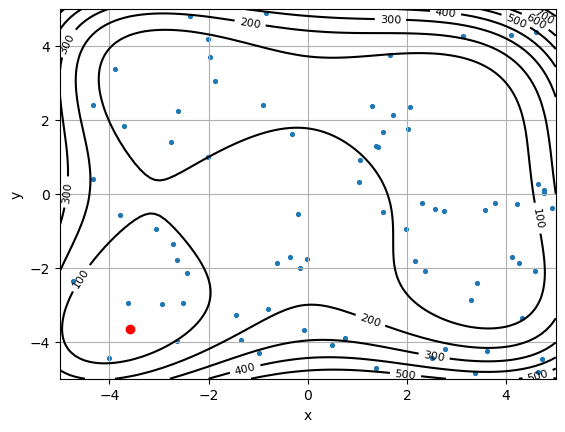

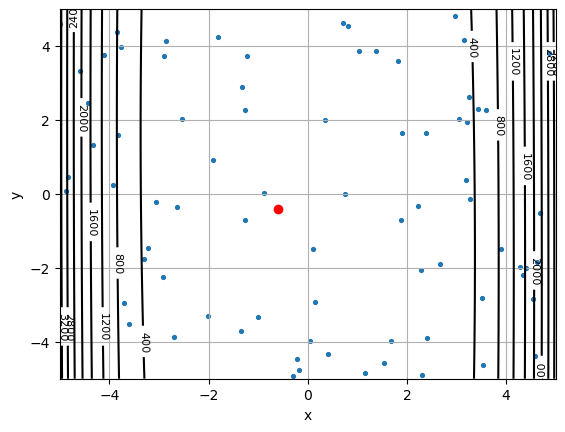

Epoch: 6 Best individual: [ 3.53830786 -2.39436339 -0.03976087  1.38214542], F(bestIndividual)=7.782437351152171


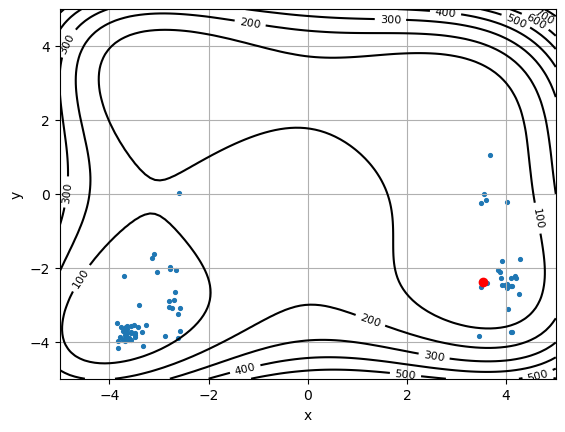

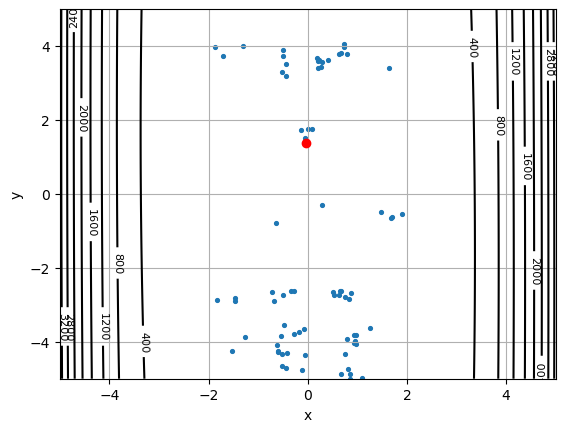

Epoch: 12 Best individual: [-3.76246363 -3.26079995  0.77035152 -0.65831247], F(bestIndividual)=1.5455036300491873


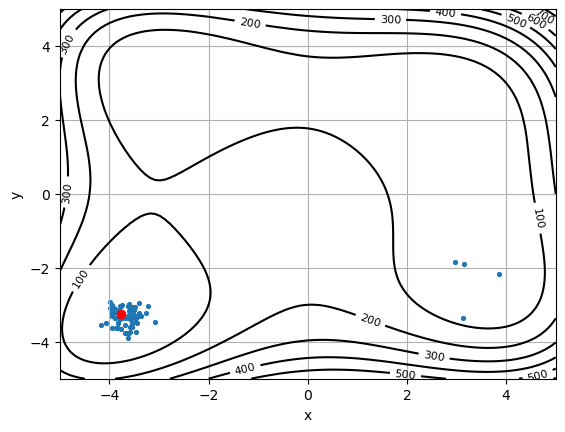

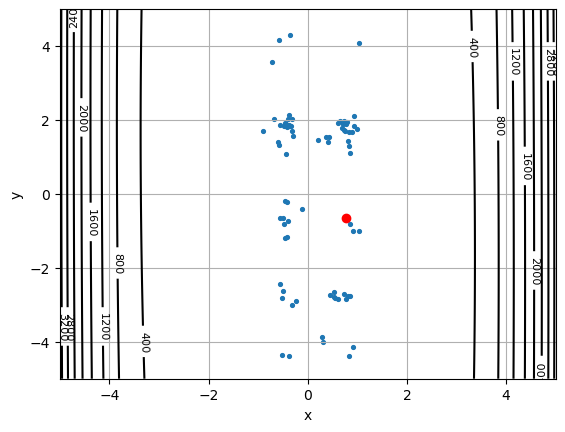

Epoch: 18 Best individual: [-3.67567603 -3.21734787 -0.07291596 -0.26037441], F(bestIndividual)=0.7021462137957948


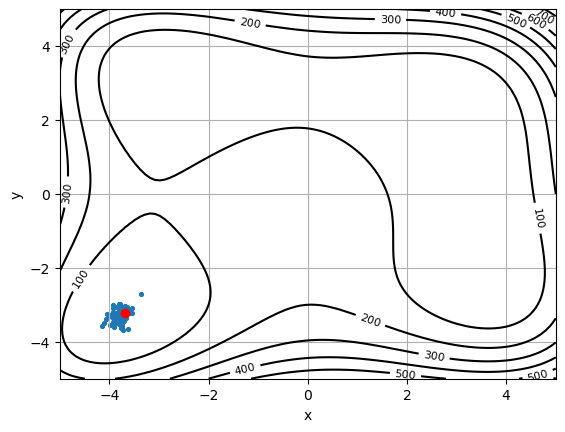

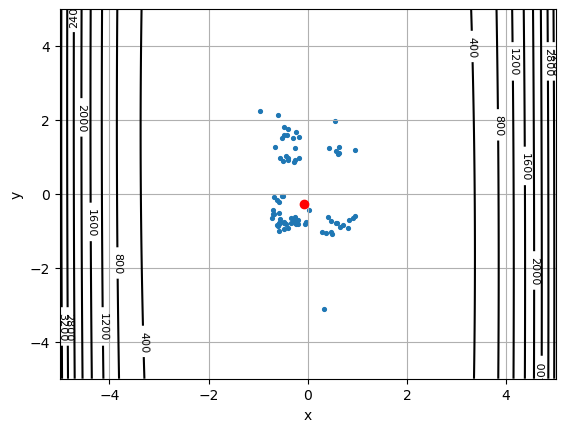

Epoch: 24 Best individual: [-3.79094763 -3.30694208 -0.06035536  0.19263576], F(bestIndividual)=0.05792261176382132


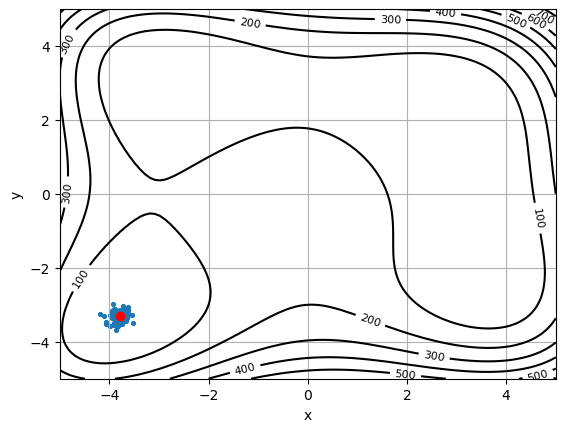

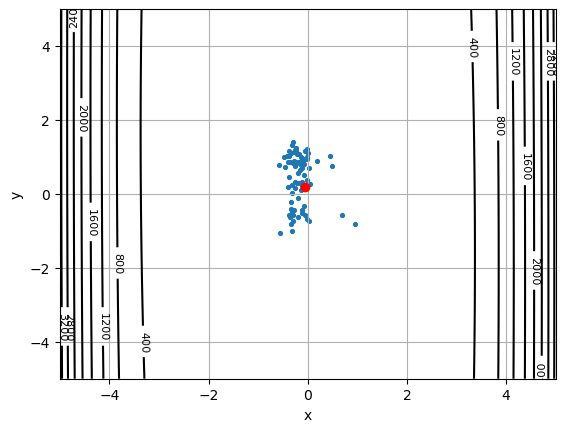

Epoch: 30 Best individual: [-3.79799109 -3.29203781 -0.11972458  0.27470343], F(bestIndividual)=0.09062826737614339


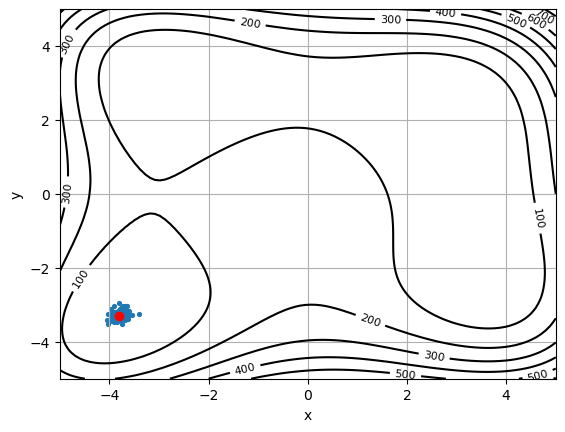

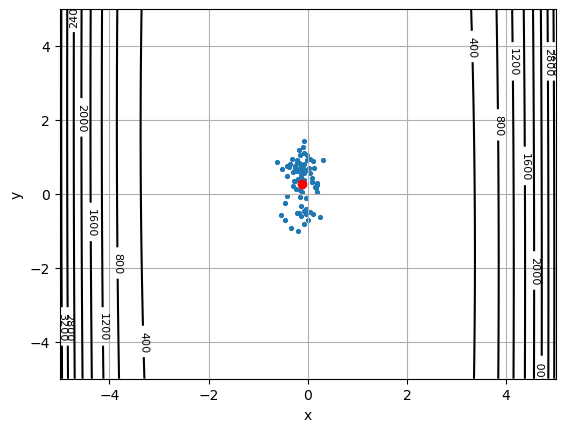

All time Best individual: [-3.79094763 -3.30694208 -0.06035536  0.19263576], F(bestIndividual)=0.05792261176382132


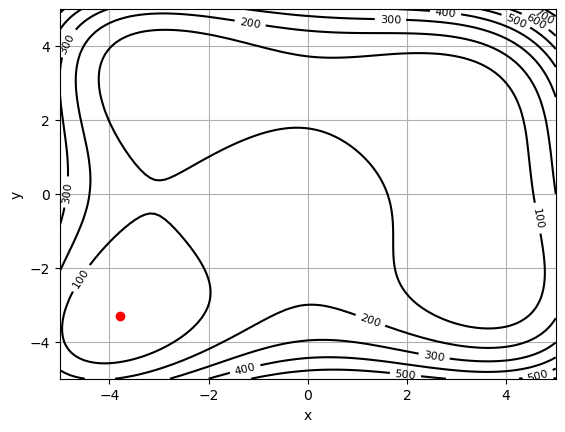

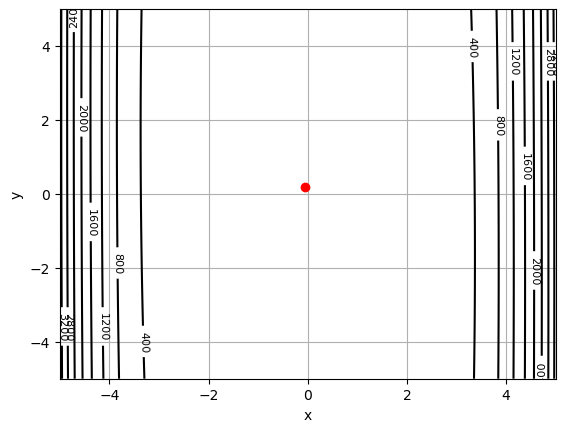

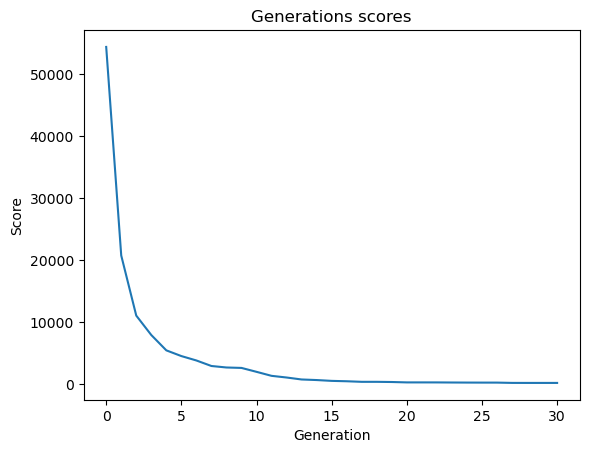

In [91]:
D=[-5,5]
size=80
step=6
crossingProbability=0.95
sigma=0.1
generations=30
printPlots(generations,D,size,step,crossingProbability,sigma)

# Wykresy dystrybucji kolejnych etapów optymalizacji z podziałem na funkcje, rozkład normalny dla x1,y1 i rozkład jednorodny dla x2,y2



Epoch: 0 Best individual: [ 1.72515043  0.51283162  0.20105604 -1.02292775], F(bestIndividual)=82.4574500644678


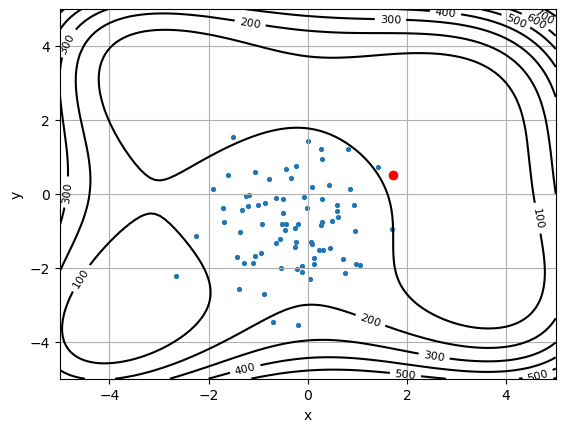

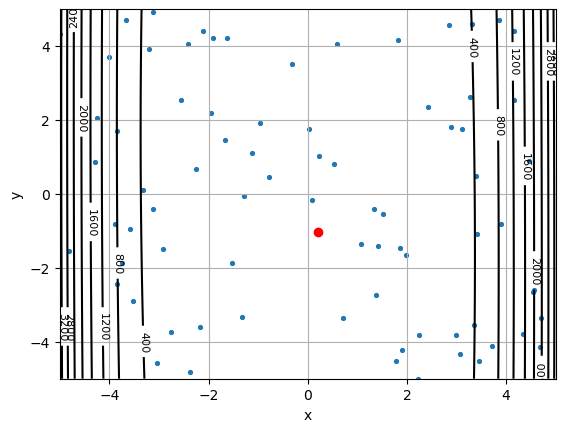

Epoch: 5 Best individual: [ 1.88545225  0.46481751  0.62515267 -1.48667381], F(bestIndividual)=74.95190556381488


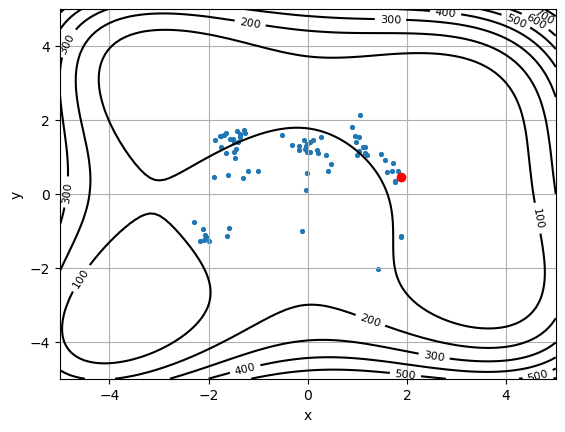

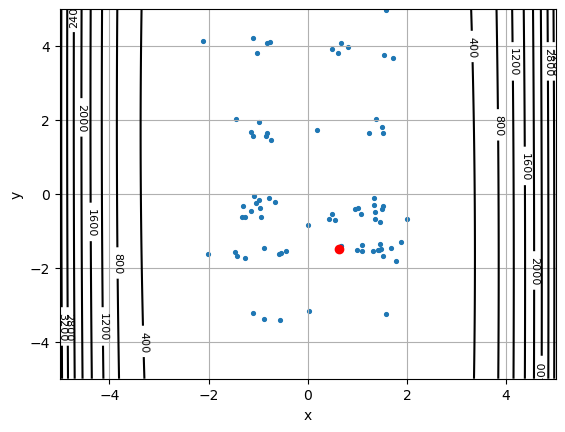

Epoch: 10 Best individual: [ 2.38474513  2.18665178  0.66203984 -1.13303419], F(bestIndividual)=11.427602771707274


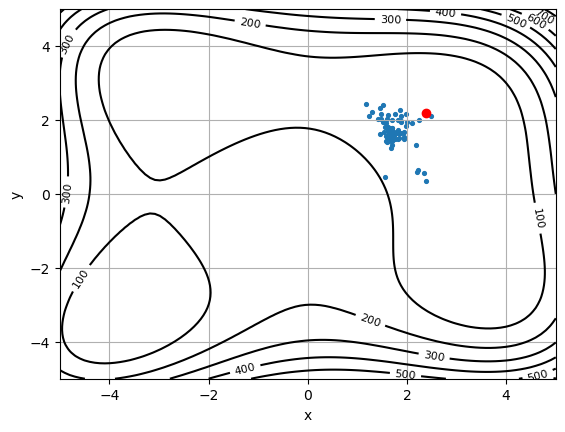

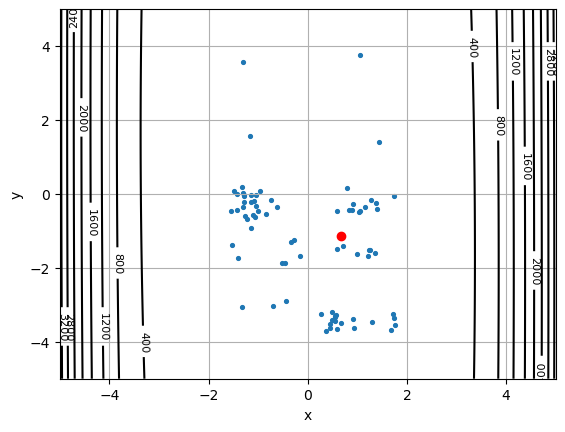

Epoch: 15 Best individual: [ 2.8391131   2.33444186 -0.19944057 -1.45472385], F(bestIndividual)=4.514426047570403


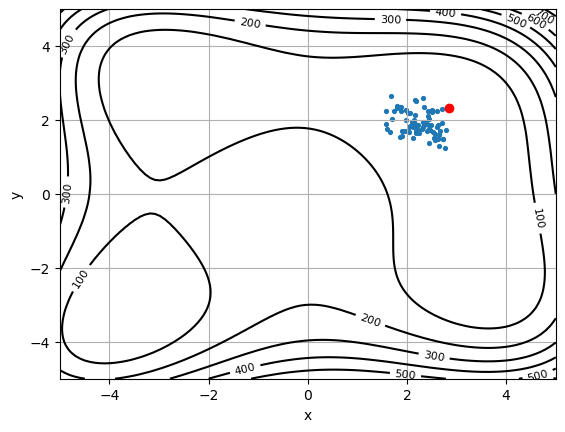

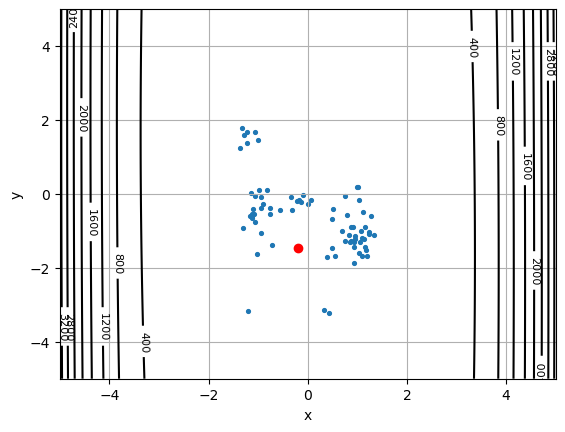

Epoch: 20 Best individual: [ 3.01331151  2.11976966 -0.19320273  0.06955492], F(bestIndividual)=0.3642326119539059


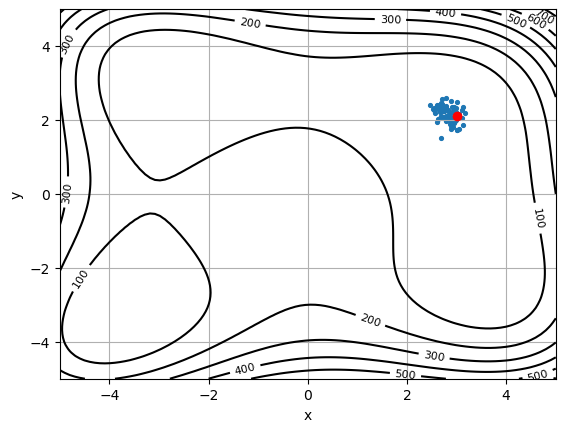

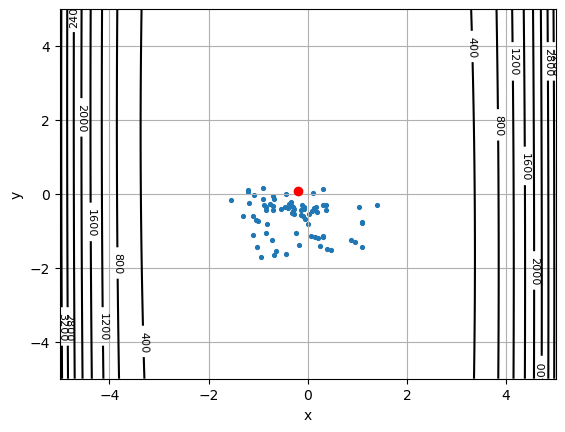

Epoch: 25 Best individual: [ 2.93474149  2.0146088   0.21118885 -0.3997421 ], F(bestIndividual)=0.3056143694320357


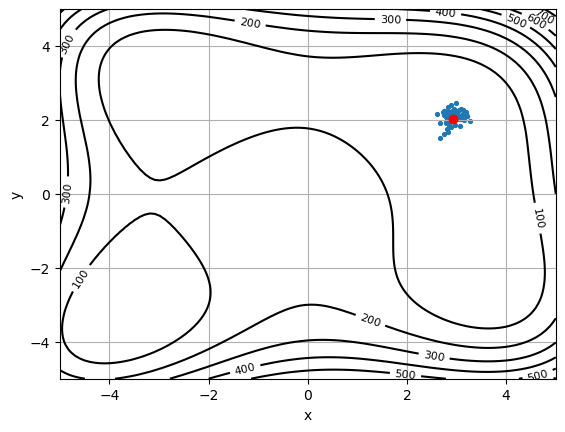

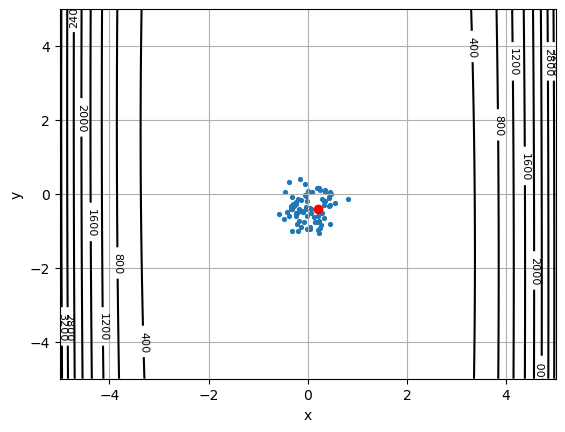

Epoch: 30 Best individual: [ 3.02874526  1.92014285 -0.11799282  0.09241091], F(bestIndividual)=0.11524570706584429


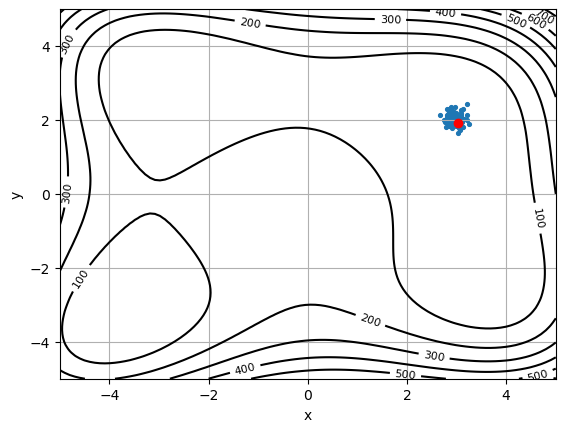

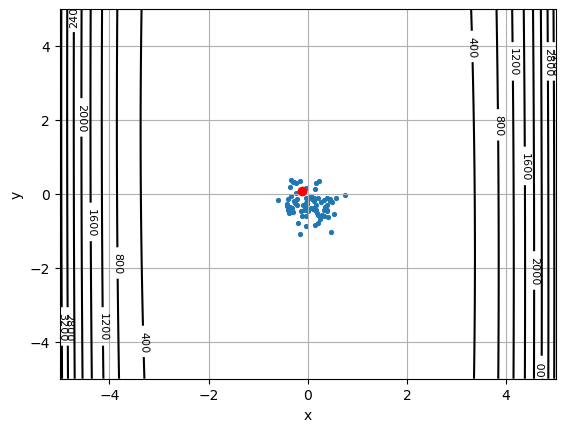

All time Best individual: [ 2.9725298   1.96881078 -0.0640217   0.03695388], F(bestIndividual)=0.06821763268018033


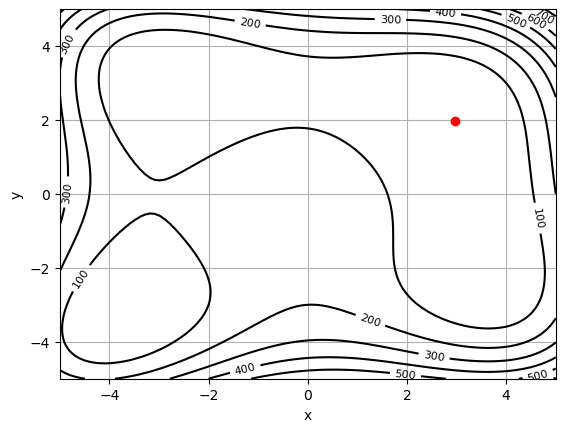

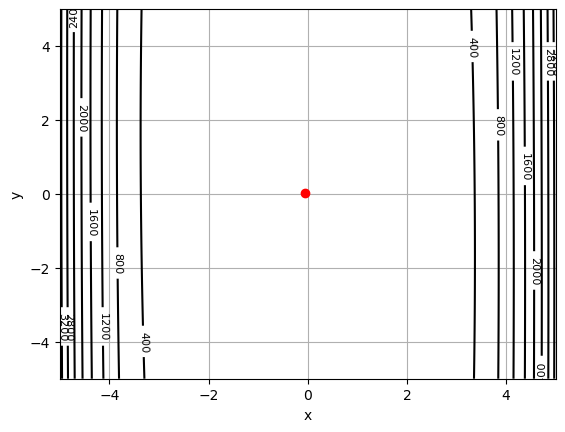

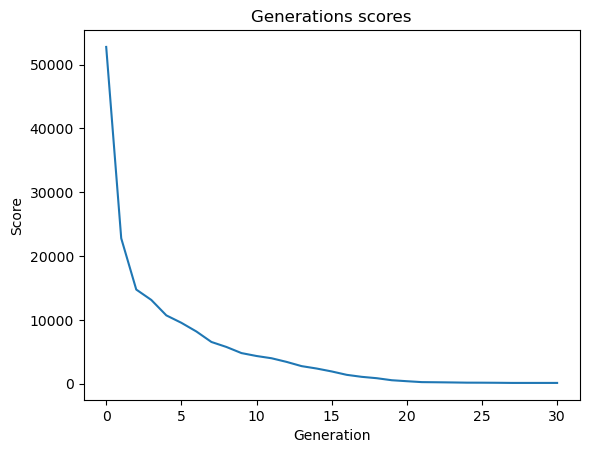

In [71]:
D=[-5,5]
size=80
step=5
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
printPlots(numberOfGenerations,D,size,step,crossingProbability,sigma,sumF1F2,startingPopulation)

# Komentarz do powyższych eksperymentów

Z powyższych wykresów i najlepszych osobników widać, że algorytm znajduje jedno z minimów. Na kolejnych etapach osobniki przybliżają się do celu. Oprócz tego na wykresie wyników poszczególnych generacji można zaobserwować, że wraz ze wzrostem postępowaniem algorytmu maleje również łączna ocena generacji. Kolejną rzeczą jest fakt, że osobniki niezależnie gdzie podążają w początkowych etapach algorytmu, ostatecznie wszystkie kończą w jednym obszarze, prawdopodobnie jest to spowodowane zastosowaniem selekcji turniejowej, która przez fakt, że osobniki są za każdym razem zwracane do puli, powoduje, że ostatecznie może być kilka takich samych osobników (przed mutacją). Ciekawym zjawiskiem jest fakt, że w ostatniej iteracji najlepszy osobnik nie musi przetrwać, ponieważ mutacje nie zwracają w żaden sposób uwagi na wartość funkcji celu danego osobnika, dlatego też jest on aktualizowany co generacje, by znaleźć możliwie najlepszy wynik.

In [56]:
def alreadyFound(x,y,foundItems):
    for item in foundItems:
        if np.absolute(item[0][0] - x) < 0.2  and np.absolute(item[0][1] - y) < 0.2:
            return True
    return False

In [83]:
def algorithmStatistics(numberOfGenerations, populationSize, crossingProbability, sigma, D, runs,startingPopulation=None, gradingFunction=sumF1F2):
    foundItems = []
    sumValue = 0
    values = []
    for _ in range(runs):
        generations, bestIndividual = evolutionAlgorithm(numberOfGenerations, populationSize, crossingProbability, sigma, D,startingPopulation, gradingFunction)
        sumValue += gradingFunction(bestIndividual)
        values.append(gradingFunction(bestIndividual))
        if not alreadyFound(bestIndividual[0], bestIndividual[1], foundItems):
            foundItems.append([[round(bestIndividual[0],1), round(bestIndividual[1],1)], 1])
        else:
            for item in foundItems:
                if np.absolute(item[0][0] - bestIndividual[0]) < 0.2  and np.absolute(item[0][1] -  bestIndividual[1]) < 0.2:
                    item[1] += 1
                    break
    standardDeviation = np.std(values)
    return foundItems, sumValue/runs, standardDeviation

In [84]:
def printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation=None,gradingFunction=sumF1F2):
    results,average,standardDeviation = algorithmStatistics(numberOfGenerations,size,crossingProbability,sigma,D,100,startingPopulation,gradingFunction)

    points = []
    count = []

    for item in results:

        points.append(item[0].__str__())
        count.append(item[1])

    plt.bar(range(len(points)),count, width=0.5,tick_label=points, align='center')

    plt.xlabel('Minimums')
    plt.ylabel('Number of occurences')
    plt.title('Number of occurences of minimums in 100 runs')


    plt.show()
    print(f'Average value: {average}')
    print(f'Standard deviation value: {standardDeviation}')
    return results

# Wpływ dystrybucji początkowej, siły mutacji i prawdopodobieństwa krzyżowania na współrzędne minimów dla funkcji f1



size: 80 crossingProbability: 0.8 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: All Random


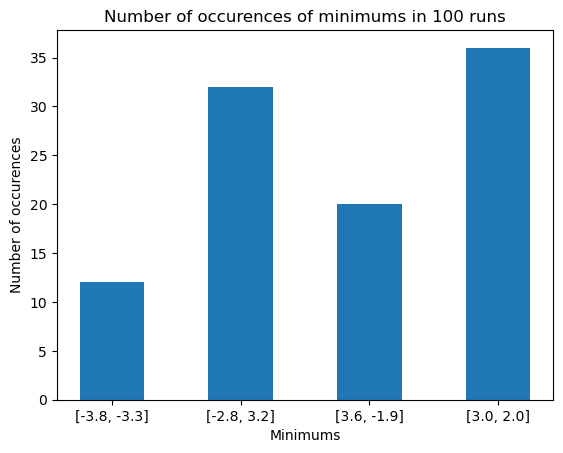

Average value: 0.09323584227314317
Standard deviation value: 0.16134832904849444
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: All Random


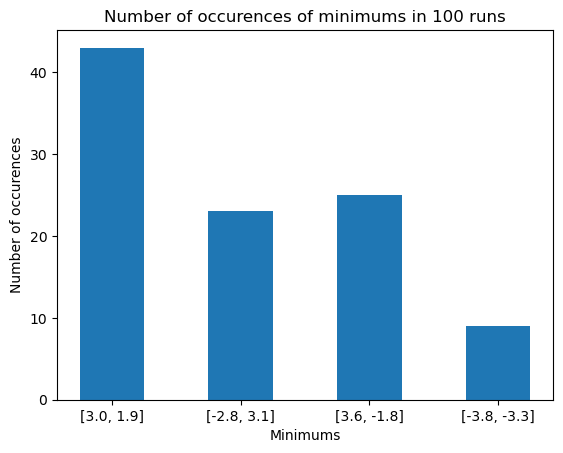

Average value: 0.09825506731735946
Standard deviation value: 0.2087824164758494
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.5 numberOfGenerations: 30 
Starting population generation type: All Random


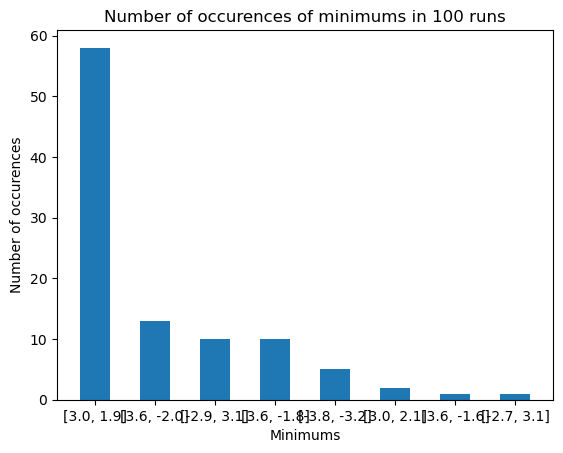

Average value: 0.4393726586617393
Standard deviation value: 0.26850840498312534
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.3 numberOfGenerations: 30 
Starting population generation type: All Random


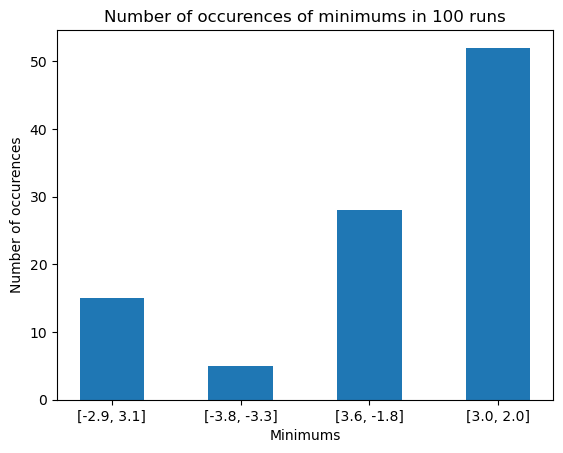

Average value: 0.21068329612815884
Standard deviation value: 0.17655046692473247
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.05 numberOfGenerations: 30 
Starting population generation type: All Random


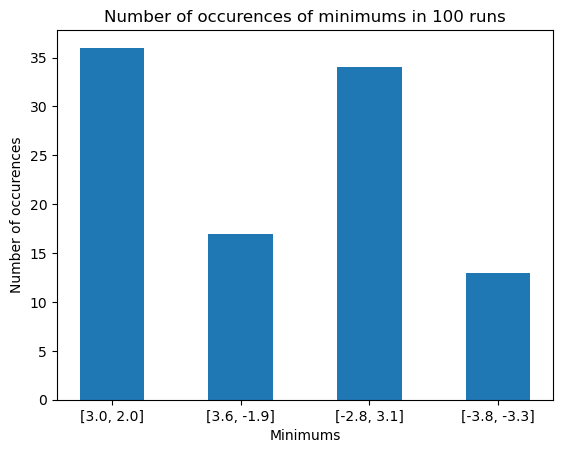

Average value: 0.12987072705070873
Standard deviation value: 0.2600999917953197
##############################################################################################################################################################################
size: 80 crossingProbability: 0.8 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


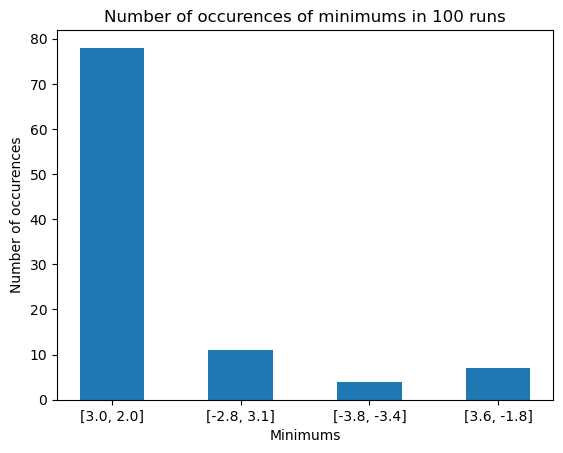

Average value: 0.10442354238937153
Standard deviation value: 0.1805576128315651
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.1 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


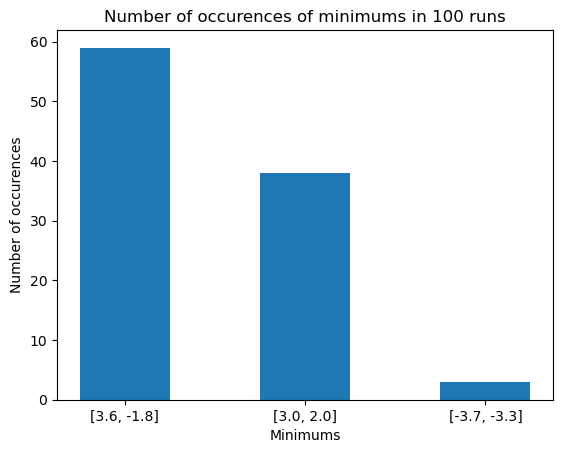

Average value: 0.06045435307762756
Standard deviation value: 0.07789241959470349
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.5 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


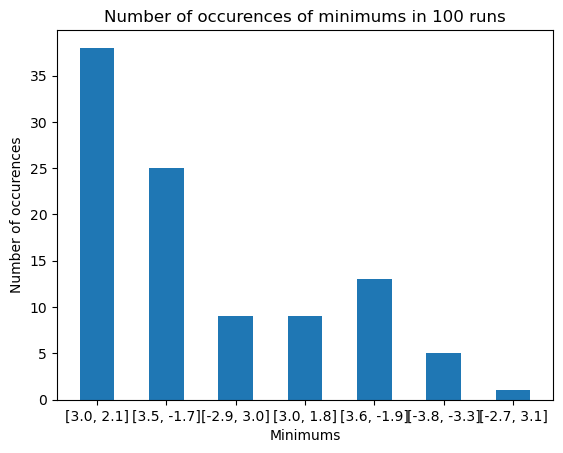

Average value: 0.43229979682428044
Standard deviation value: 0.27478662653989366
##############################################################################################################################################################################
size: 80 crossingProbability: 0.95 sigma: 0.3 numberOfGenerations: 30 
Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]


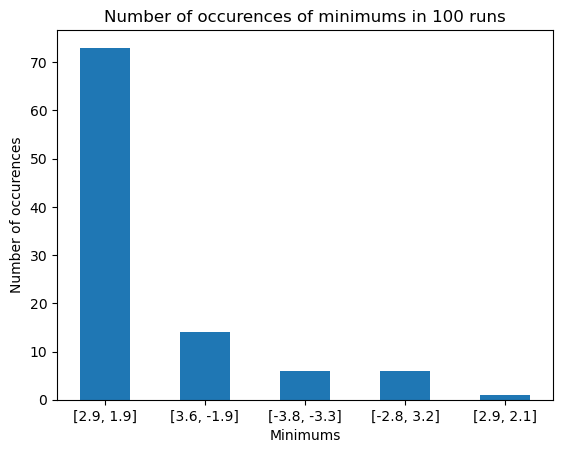

Average value: 0.20525750432653553
Standard deviation value: 0.14366444306805834
##############################################################################################################################################################################


In [88]:
res = []
D=[-5,5]
size=80
numberOfGenerations=30

crossingProbability=0.8
sigma=0.1
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D))

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D))

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.5
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D))

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.3
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D))


print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.05
numberOfGenerations=30

print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: All Random')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D))

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.8
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation))

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.1
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation))

print("##############################################################################################################################################################################")

D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.5
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation))

print("##############################################################################################################################################################################")


D=[-5,5]
size=80
crossingProbability=0.95
sigma=0.3
numberOfGenerations=30
startingPopulation = generateSpecificF1Population(size, [-0.3,-0.9], 1, D)
print(f'size: {size} crossingProbability: {crossingProbability} sigma: {sigma} numberOfGenerations: {numberOfGenerations} ')
print(f'Starting population generation type: Normal Distribution Around Point (x1,y1) = [-0.3,-0.9]')
res.append(printStatistics(numberOfGenerations,size,crossingProbability,sigma,D,startingPopulation))

print("##############################################################################################################################################################################")

# Zestawienie Wyników: 
| Sposób Generacji Populacji Początkowej | Siła Mutacji | Rozmiar Populacji | Prawdopodobieństwo Krzyżowania | Liczba Generacji | Średnia Wartość | Odchylenie Standardowe | punkt [3.0,2.0] | punkt [-2.8,3.1] | punkt [3.6,-1.8] | punkt [-3.8,-3.3] |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Rozkład jednorodny | 0.1 | 80 | 0.8 | 30 | 0.09323584227314317 | 0.16134832904849444 | 36 | 32 | 20 | 12 |
| Rozkład jednorodny | 0.1 | 80 | 0.95 | 30 | 0.09825506731735946 | 0.2087824164758494 | 43 | 23 | 25 | 9 |
| Rozkład jednorodny | 0.5 | 80 | 0.95 | 30 | 0.4393726586617393 | 0.26850840498312534 | 60 | 11 | 24 | 5 |
| Rozkład jednorodny | 0.3 | 80 | 0.95 | 30 | 0.21068329612815884 | 0.17655046692473247 | 52 | 15 | 28 | 5 |
| Rozkład jednorodny | 0.05 | 80 | 0.95 | 30 | 0.12987072705070873 |  0.2600999917953197 | 36 | 34 | 17 | 13 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.1 | 80 | 0.8 | 30 | 0.10442354238937153 | 0.1805576128315651 | 78 | 11 | 7 | 4 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.1 | 80 | 0.95 | 30 | 0.06045435307762756 | 0.07789241959470349 | 38 | 0 | 59 | 3 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.5 | 80 | 0.95 | 30 | 0.43229979682428044 | 0.27478662653989366 | 48 | 10 | 38 | 5 |
| Rozkład normalny dla x1,y1 dla innych jednorodny | 0.3 | 80 | 0.95 | 30 | 0.20525750432653553 | 0.14366444306805834 | 74 | 6 | 14 | 6 |


*Rozkład normalny dla x1,y1 wokół punktu [-0.3,-0.9]*


# Komentarz do powyższych eksperymentów
Niezależnie od parametrów eksperymentu najczęściej znajdowanym minimum funkcji f1 są okolice punktu [3.0,2.0], dzieje się tak ze względu na charakterystykę tej funkcji, mianowicie w tym algorytmie przy selekcji turniejowej statystycznie częściej dalej przechodzą osobniki o najniższej funkcji celu, a ta wartość prawdopodobnie jest najkorzystniejsza właśnie w kierunku punktu [3.0,2.0]. Zmiana dystrybucji punktów na taką o rozkładzie normalnym wokół punktu [-0.3,-0.9] pogłębia ten efekt, dla określonych sił mutacji. Można też zauważyć, że określone siły mutacji, a także prawdopodobieństwa krzyżowania powodują wzmożone znajdowanie określonych minimów. Zmiana dystrybucji nie wpływa większym stopniu na jakość działania, a jedynie na znajdowane minima. Wnioskuje to z faktu, że wartość średnia i odchylenie standardowe nieznacznie się tylko różnią w stosunku do rozkładu jednorodnego, przy tych samych parametrach. Najlepszą wartość średnią osiągnął algorytm z rozkładem jednorodnym, przy sile mutacji = 0.1 i prawdopodobieństwie krzyżowania = 0.95, jednak jest to nieduża różnica w stosunku do rozkładu jednorodnego o tych samych parametrach i prawdopodobnie jest losowa. Dlatego takie parametry bym wybrał niezależnie od rozkładu. Oprócz tego w kwestii parametrów widać, że siła mutacji = 0.5 jest już zbyt wysoka, ponieważ błąd jest około 7 razy większy dla tych wyników, co do prawdopodobieństwa krzyżowania w przedziale 0.8-0.95 każda wartość wydaje się być odpowiednia i nie ma znaczącego wpływu na efektywność. 

# Podsumowanie i ocena algorytmu
Algorytm sprawdza się dobrze, bez problemu odnajduje minima w podanej funkcji, wpływ punktu początkowego jest mniej znaczący na efektywność niż przy algorytmie najszybszego spadku, co czyni go bardziej odpornym na losowe czynniki. Jego minusem jest duża ilość parametrów, które trzeba wybrać, natomiast zdecydowanym atutem jest fakt, że do optymalizacji nie jest potrzebny gradient, a jedynie funkcja. Algorytm nie potrzebował dużej ilości iteracji do znalezienia minimum, jednak nie jestem w stanie powiedzieć czy dla przeszukiwania dużych obszarów byłby tak efektywny.